In [13]:
import torch
import torchvision
from torchvision.utils import make_grid, save_image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg
from configparser import ConfigParser
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import common.setup as setup

In [14]:
model_name = 'VAE'
model_path = '../trained_models/VAE_MNIST_2020-01-24_17-02/final_model.pth.tar'
config_path = os.path.join(os.path.dirname(model_path), 'settings.ini')
config = ConfigParser()
config.read(config_path)
loader = setup.create_dataset_loader(config, data='MNIST', test=True, directory='../data')
n_classes = 10 if config.getboolean('HYPERPARAMS', 'auxillary') else -1
model = setup.create_model(config, model_name, num_classes=n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

Given 10000 training points (batch size: 1)


<All keys matched successfully>

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('done')

done


## Test reconstruction of test samples

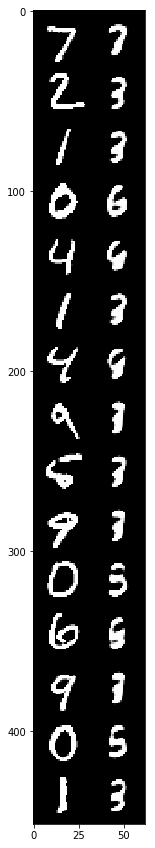

In [16]:
imgs = []
n = 15
for i, (data, target) in enumerate(loader):
    if i > n-1:
        break
    imgs.append(data.squeeze(0))
    mu, log_var, c = model.encode(data.to(device))
    z = model.sample_z(mu, log_var)
    rec = model.decode(mu)
    rec = rec.detach().cpu()
    #print('mu: %s\n\var: %s\n'%(str(mu), str(log_var)))
    imgs.append(rec.squeeze(0))

imgs = torch.clamp(make_grid(imgs, nrow=2), 0, 1)
imgs = np.moveaxis(imgs.numpy(), 0, -1)
plt.figure(figsize=(2.0, n))
plt.imshow(imgs)
plt.show()

## Create new samples

In [17]:
latent_dim =  config.getint('HYPERPARAMS', 'latent_dim')
eps = torch.randn((1, latent_dim), device=device)
print(eps.size())
print(z.size())
img = model.decode(eps)
img = img.squeeze().detach().cpu().numpy()
print(img.shape)

torch.Size([1, 2])
torch.Size([1, 2])
(28, 28)


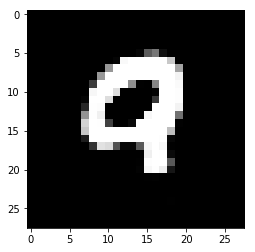

In [18]:
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

### Variety of generated samples

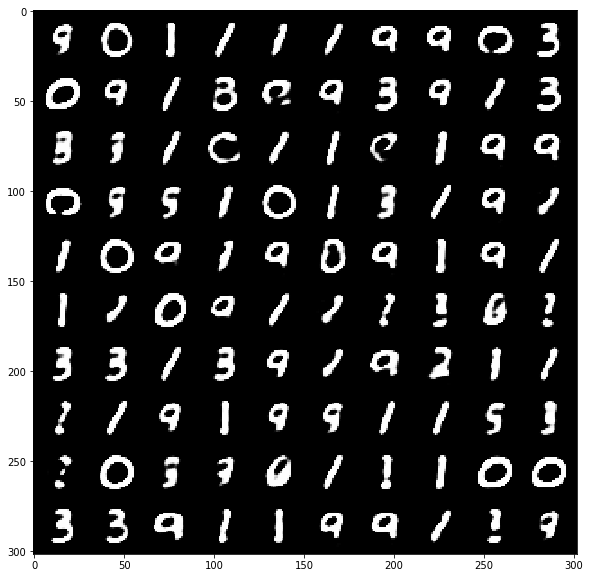

In [19]:
square = 10
imgs = []
eps = torch.randn((square**2, latent_dim), device=device)
#eps = mu + torch.exp(log_var / 2) * eps
imgs = model.decode(eps)
imgs = imgs.squeeze(0).detach().cpu()
imgs = make_grid(imgs, nrow=square)
plt.figure(figsize=(square, square))
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.show()

In [20]:
if config.getint('HYPERPARAMS', 'latent_dim') != 2:
    import warnings
    warnings.warn('Under this cell the model needs the encoding to be two-dimensional!', Warning)

## Show regularity in created samples

In [21]:
def plot_img(x, y):
    z = torch.Tensor([[x, y]]).to(device)
    img = model.decode(z)
    img = img.squeeze().detach().cpu()
    plt.imshow(img, cmap=plt.cm.gray)
    return None

In [22]:
borders = 5.0
wdg.interact(plot_img, x=wdg.FloatSlider(min=-borders, max=borders, step=0.1),y=wdg.FloatSlider(min=-borders, max=borders, step=0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

<function __main__.plot_img(x, y)>

Num per dim: 25


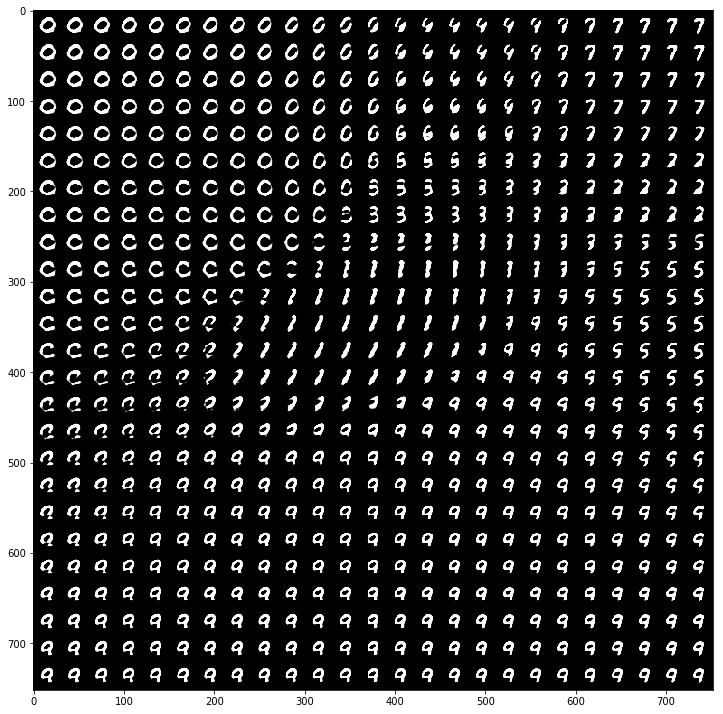

In [26]:
borders = 3.0
spacing = 0.25

num = int((borders*2)/spacing+1.0)
print('Num per dim: %d'%num)
X = np.linspace(-borders, borders, num=num)
Y = np.linspace(-borders, borders, num=num)
imgs = []
for x in X:
    for y in Y:
        z = torch.Tensor([[x, y]]).to(device)
        img = model.decode(z)
        img = img.squeeze(0).detach().cpu()
        imgs.append(img)
imgs = make_grid(imgs, nrow=num)
plt.figure(figsize=(num/2.0, num/2.0))
plt.imshow(np.moveaxis(imgs.numpy(), 0, -1), cmap=plt.cm.gray)
plt.savefig('../result_figures/VAE_generation.png')
plt.show()